In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from tabulate import tabulate 

from collections import defaultdict, OrderedDict
from common import *  # load_csv, normalize_df, env_ids, algo_names, load_total_dfs, normalizer, task_id_conv

In [2]:
total_dfs, errors = load_total_dfs(normalize=True)

/home/mrn/my_repos/mir-gan/scripts/common.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = normalized
/home/mrn/my_repos/mir-gan/scripts/common.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = normalized
/home/mrn/my_repos/mir-gan/scripts/common.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `n

In [3]:
def get_mean_std(total_dfs, env_id, algo):
    related_dfs = total_dfs[algo][env_id]
    des_cols = [f'{mode}/{context}_normal_avg' for mode in ['train', 'moderate', 'extreme'] for context in ['offline', 'online', 'nonprior']]
    result = {}
    for col in des_cols:
        values = [df[col].to_numpy()[-5:].mean() for df in related_dfs]
        values = [x for x in values if str(x) != 'nan']
        result[col] = (np.mean(values), np.std(values))
    return result 

In [4]:
get_mean_std(total_dfs, env_id='cheetah-vel-custom', algo='ER-TRL')

{'train/offline_normal_avg': (96.35667177343207, 0.1939230302542735),
 'train/online_normal_avg': (92.46964908070109, 0.3645918902352709),
 'train/nonprior_normal_avg': (94.20611971287022, 0.3542393096751636),
 'moderate/offline_normal_avg': (72.60825900671614, 1.3858192662696902),
 'moderate/online_normal_avg': (61.846183656781065, 2.1836282848770865),
 'moderate/nonprior_normal_avg': (70.38282193660805, 1.2204975288552953),
 'extreme/offline_normal_avg': (-410.30298139306433, 9.213622405850549),
 'extreme/online_normal_avg': (-182.49599618463063, 9.920506212912862),
 'extreme/nonprior_normal_avg': (-106.17753914422444, 5.973069380804032)}

In [5]:
def return_mean_std(total_dfs, mode, context): 
    means = {}
    stds = {}
    for algo in algo_names:
        means[algo] = []
        stds[algo] = []
        for env in env_ids:
            mu, st = get_mean_std(total_dfs, env_id=env, algo=algo)[f'{mode}/{context}_normal_avg']
            means[algo].append(mu)
            stds[algo].append(st)
        means[algo] = np.array(means[algo])
        stds[algo] = np.array(stds[algo])
    return means, stds 

In [6]:
means, stds = return_mean_std(total_dfs, 'train', 'nonprior')

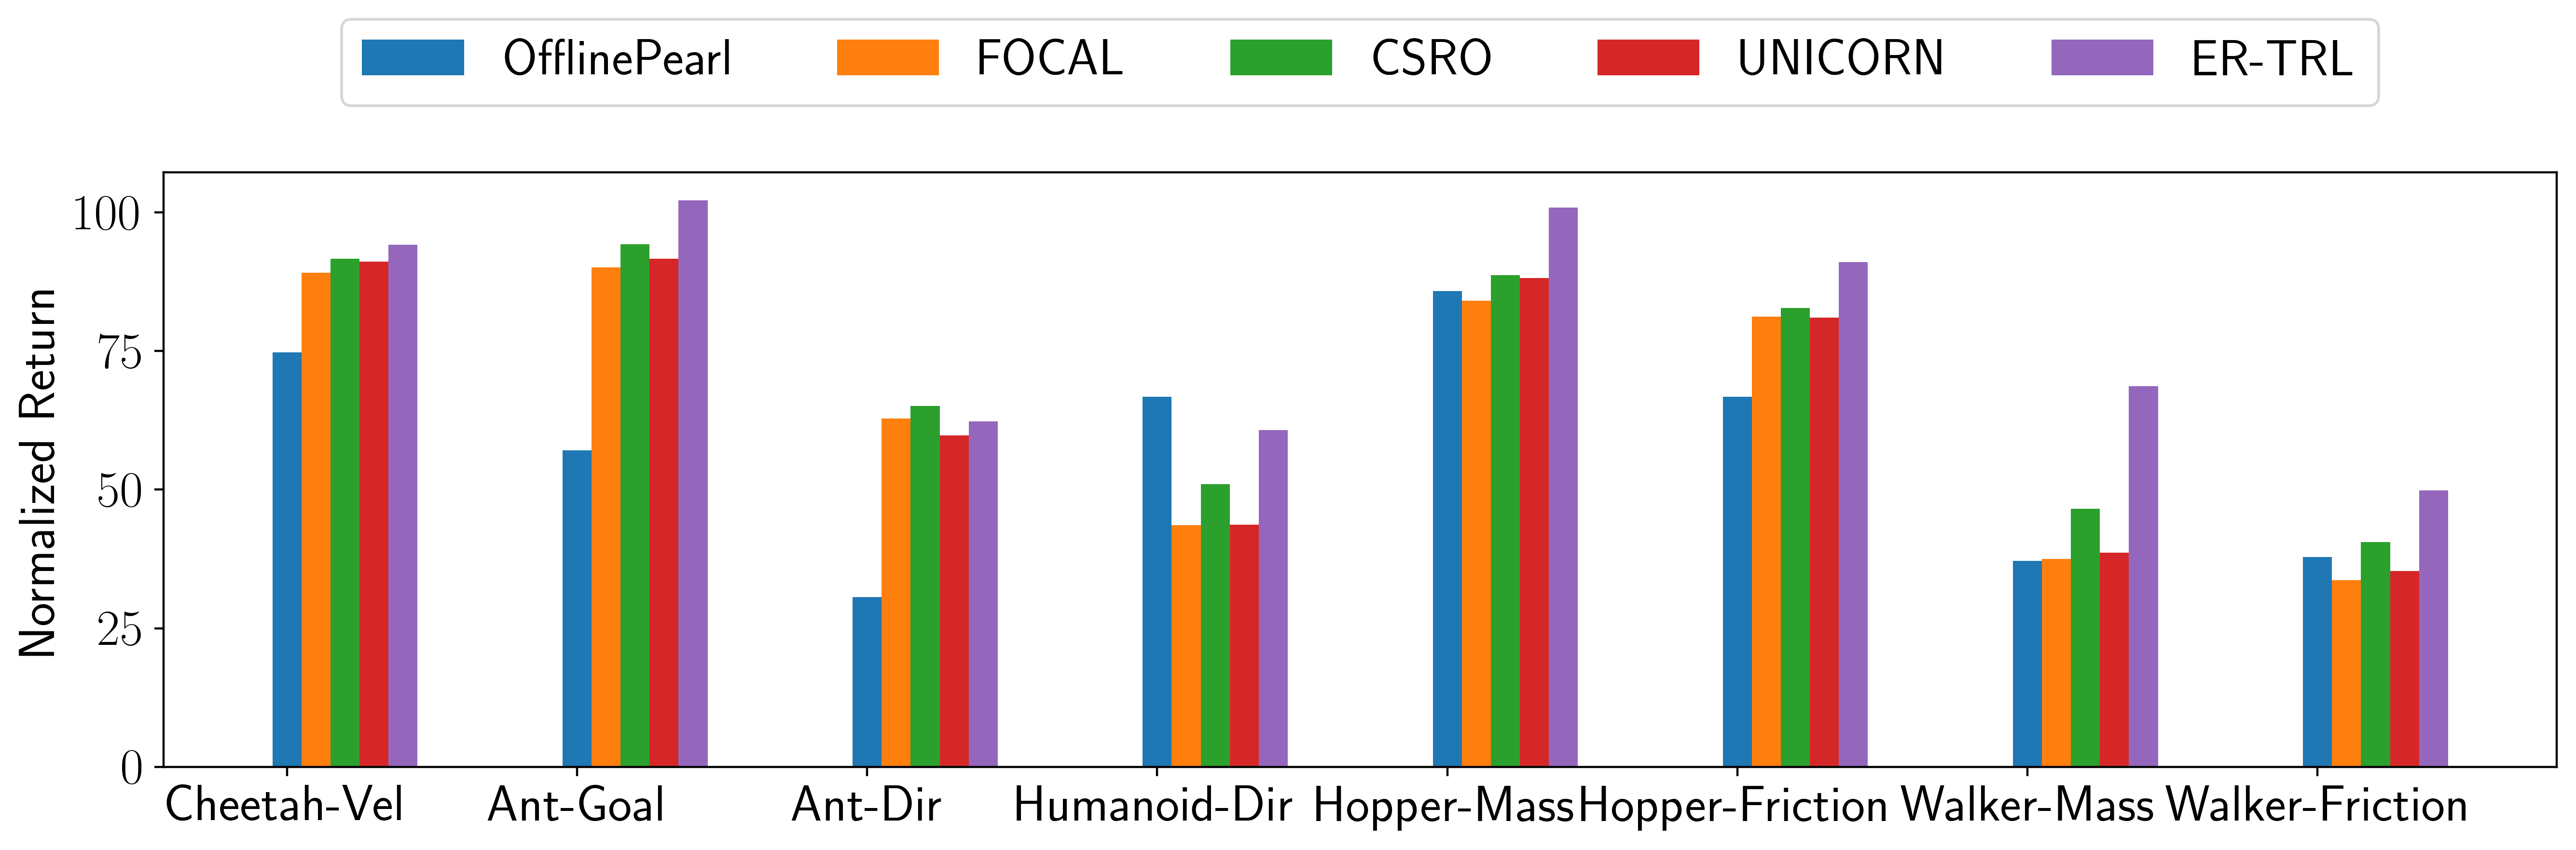

In [7]:
plt.rcParams["figure.dpi"] = 400
plt.rcParams["font.size"] = 19
plt.rcParams["legend.fontsize"] = 19
plt.rcParams["text.usetex"] = True

fig, axs = plt.subplots(1, 1, figsize=(16, 4), sharex=True)
x = np.arange(len(env_ids))  # the label locations
xticks = [env_names[env] for env in env_ids]
width = 0.1  # the width of the bars
multiplier = 1
for algo, mean in means.items():
    offset = width * multiplier
    rects_offline = axs.bar(x + offset, mean, width, label=algo)#yerr=(mean-stds[algo], mean+stds[algo]))
    multiplier += 1
axs.set_ylabel('Normalized Return')

axs.set_xticks(x + width, xticks)
axs.legend(loc='upper center', ncol=5,bbox_to_anchor=(0.5,1.3))

In [8]:
# total_dfs, errors = load_total_dfs(normalize=False)

In [9]:
def make_table(total_dfs, mode, context):
    means, stds = return_mean_std(total_dfs, mode, context)
    result = {}
    result['Environment'] = [env_names[env] for env in env_ids]
    result['context'] = ['\multirow{8}{*}{Offline}', ]
    for key in algo_names:
        strings = []
        values = means[key]
        for i in range(len(values)):
            mean, std = means[key][i], stds[key][i]
            arr = f'$ {mean:.1f} \pm {std:.1f} $'
            strings.append(arr)
        result[key] = strings
    print(tabulate(result, tablefmt='latex_raw', headers=result.keys()))
    return None 


<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_25763/3724489904.py:5: SyntaxWarning: invalid escape sequence '\m'
  result['context'] = ['\multirow{8}{*}{Offline}', ]
/tmp/ipykernel_25763/3724489904.py:11: SyntaxWarning: invalid escape sequence '\p'
  arr = f'$ {mean:.1f} \pm {std:.1f} $'


In [10]:
make_table(total_dfs, mode='train', context='offline')

\begin{tabular}{lllllll}
\hline
 Environment     & context                  & OfflinePearl      & FOCAL             & CSRO              & UNICORN           & ER-TRL            \\
\hline
 Cheetah-Vel     & \multirow{8}{*}{Offline} & $ 83.3 \pm 20.3 $ & $ 92.8 \pm 1.4 $  & $ 94.0 \pm 0.7 $  & $ 93.5 \pm 0.8 $  & $ 96.4 \pm 0.2 $  \\
 Ant-Goal        &                          & $ 99.0 \pm 3.7 $  & $ 93.9 \pm 2.8 $  & $ 94.6 \pm 3.7 $  & $ 95.5 \pm 2.7 $  & $ 107.7 \pm 2.5 $ \\
 Ant-Dir         &                          & $ 28.7 \pm 3.0 $  & $ 60.7 \pm 1.7 $  & $ 65.2 \pm 4.7 $  & $ 62.3 \pm 1.9 $  & $ 69.1 \pm 4.6 $  \\
 Humanoid-Dir    &                          & $ 66.3 \pm 4.2 $  & $ 62.1 \pm 2.0 $  & $ 56.3 \pm 1.4 $  & $ 58.0 \pm 2.2 $  & $ 70.5 \pm 5.5 $  \\
 Hopper-Mass     &                          & $ 89.5 \pm 9.4 $  & $ 79.4 \pm 11.0 $ & $ 83.7 \pm 12.1 $ & $ 85.8 \pm 9.6 $  & $ 98.7 \pm 0.3 $  \\
 Hopper-Friction &                          & $ 79.4 \pm 11.9 $ & $ 80.8 \pm 14

In [11]:
make_table(total_dfs, mode='train', context='online')

\begin{tabular}{lllllll}
\hline
 Environment     & context                  & OfflinePearl      & FOCAL             & CSRO              & UNICORN           & ER-TRL            \\
\hline
 Cheetah-Vel     & \multirow{8}{*}{Offline} & $ 80.0 \pm 19.2 $ & $ 86.0 \pm 1.8 $  & $ 89.3 \pm 1.8 $  & $ 88.2 \pm 1.7 $  & $ 92.5 \pm 0.4 $  \\
 Ant-Goal        &                          & $ 49.1 \pm 3.2 $  & $ 77.2 \pm 3.2 $  & $ 80.9 \pm 4.4 $  & $ 79.0 \pm 2.1 $  & $ 93.1 \pm 2.0 $  \\
 Ant-Dir         &                          & $ 29.1 \pm 3.8 $  & $ 42.4 \pm 5.2 $  & $ 54.6 \pm 3.9 $  & $ 41.2 \pm 5.1 $  & $ 53.6 \pm 11.6 $ \\
 Humanoid-Dir    &                          & $ 66.9 \pm 5.7 $  & $ 54.4 \pm 1.9 $  & $ 52.1 \pm 3.1 $  & $ 44.9 \pm 2.1 $  & $ 61.4 \pm 2.4 $  \\
 Hopper-Mass     &                          & $ 88.2 \pm 8.8 $  & $ 86.5 \pm 8.2 $  & $ 88.8 \pm 3.7 $  & $ 84.4 \pm 12.2 $ & $ 99.7 \pm 1.1 $  \\
 Hopper-Friction &                          & $ 65.9 \pm 13.6 $ & $ 74.3 \pm 30

In [12]:
make_table(total_dfs, mode='moderate', context='offline')

\begin{tabular}{lllllll}
\hline
 Environment     & context                  & OfflinePearl      & FOCAL             & CSRO             & UNICORN          & ER-TRL            \\
\hline
 Cheetah-Vel     & \multirow{8}{*}{Offline} & $ 66.2 \pm 14.4 $ & $ 69.3 \pm 1.0 $  & $ 66.5 \pm 2.7 $ & $ 66.4 \pm 1.6 $ & $ 72.6 \pm 1.4 $  \\
 Ant-Goal        &                          & $ 82.2 \pm 4.7 $  & $ 61.4 \pm 5.6 $  & $ 52.0 \pm 3.7 $ & $ 61.6 \pm 3.4 $ & $ 79.1 \pm 4.1 $  \\
 Ant-Dir         &                          & $ -18.9 \pm 3.2 $ & $ 47.7 \pm 3.3 $  & $ 51.5 \pm 4.0 $ & $ 50.2 \pm 2.3 $ & $ 54.9 \pm 2.8 $  \\
 Humanoid-Dir    &                          & $ 61.3 \pm 6.9 $  & $ 49.1 \pm 2.6 $  & $ 48.9 \pm 2.8 $ & $ 44.8 \pm 2.3 $ & $ 59.9 \pm 2.8 $  \\
 Hopper-Mass     &                          & $ 84.1 \pm 15.5 $ & $ 80.6 \pm 14.5 $ & $ 80.2 \pm 7.5 $ & $ 83.9 \pm 8.1 $ & $ 99.7 \pm 0.9 $  \\
 Hopper-Friction &                          & $ 51.6 \pm 10.0 $ & $ 57.8 \pm 7.2 $  & $ 63.

In [13]:
make_table(total_dfs, mode='moderate', context='online')

\begin{tabular}{lllllll}
\hline
 Environment     & context                  & OfflinePearl      & FOCAL             & CSRO              & UNICORN           & ER-TRL           \\
\hline
 Cheetah-Vel     & \multirow{8}{*}{Offline} & $ 56.2 \pm 10.6 $ & $ 54.9 \pm 3.5 $  & $ 50.6 \pm 11.1 $ & $ 51.6 \pm 3.2 $  & $ 61.8 \pm 2.2 $ \\
 Ant-Goal        &                          & $ 20.1 \pm 5.0 $  & $ 29.2 \pm 5.6 $  & $ 26.4 \pm 3.6 $  & $ 26.3 \pm 4.9 $  & $ 49.1 \pm 4.3 $ \\
 Ant-Dir         &                          & $ -19.9 \pm 4.0 $ & $ 4.0 \pm 3.6 $   & $ 8.5 \pm 6.6 $   & $ 4.5 \pm 7.9 $   & $ 27.6 \pm 5.5 $ \\
 Humanoid-Dir    &                          & $ 59.4 \pm 7.0 $  & $ 44.4 \pm 3.7 $  & $ 46.7 \pm 5.8 $  & $ 36.6 \pm 1.8 $  & $ 53.4 \pm 3.3 $ \\
 Hopper-Mass     &                          & $ 77.4 \pm 12.1 $ & $ 81.6 \pm 9.3 $  & $ 84.8 \pm 10.1 $ & $ 83.4 \pm 5.8 $  & $ 99.6 \pm 1.4 $ \\
 Hopper-Friction &                          & $ 48.0 \pm 10.9 $ & $ 56.9 \pm 12.6 $ &

In [14]:
make_table(total_dfs, mode='train', context='nonprior')

\begin{tabular}{lllllll}
\hline
 Environment     & context                  & OfflinePearl      & FOCAL             & CSRO              & UNICORN           & ER-TRL            \\
\hline
 Cheetah-Vel     & \multirow{8}{*}{Offline} & $ 74.8 \pm 17.1 $ & $ 89.1 \pm 1.6 $  & $ 91.7 \pm 1.0 $  & $ 91.1 \pm 0.8 $  & $ 94.2 \pm 0.4 $  \\
 Ant-Goal        &                          & $ 57.1 \pm 2.8 $  & $ 90.1 \pm 3.5 $  & $ 94.2 \pm 3.7 $  & $ 91.7 \pm 2.5 $  & $ 102.2 \pm 2.7 $ \\
 Ant-Dir         &                          & $ 30.6 \pm 5.2 $  & $ 62.8 \pm 2.7 $  & $ 65.1 \pm 4.2 $  & $ 59.8 \pm 6.2 $  & $ 62.3 \pm 12.7 $ \\
 Humanoid-Dir    &                          & $ 66.7 \pm 3.9 $  & $ 43.6 \pm 6.7 $  & $ 51.0 \pm 6.8 $  & $ 43.7 \pm 3.8 $  & $ 60.7 \pm 5.4 $  \\
 Hopper-Mass     &                          & $ 85.9 \pm 9.9 $  & $ 84.1 \pm 9.7 $  & $ 88.7 \pm 4.1 $  & $ 88.1 \pm 7.2 $  & $ 100.9 \pm 1.6 $ \\
 Hopper-Friction &                          & $ 66.8 \pm 10.2 $ & $ 81.2 \pm 15

In [15]:
make_table(total_dfs, mode='moderate', context='nonprior')

\begin{tabular}{lllllll}
\hline
 Environment     & context                  & OfflinePearl      & FOCAL             & CSRO              & UNICORN           & ER-TRL           \\
\hline
 Cheetah-Vel     & \multirow{8}{*}{Offline} & $ 55.4 \pm 5.6 $  & $ 66.9 \pm 3.4 $  & $ 63.7 \pm 3.3 $  & $ 62.1 \pm 1.7 $  & $ 70.4 \pm 1.2 $ \\
 Ant-Goal        &                          & $ 23.6 \pm 4.1 $  & $ 48.3 \pm 3.1 $  & $ 44.8 \pm 4.2 $  & $ 47.6 \pm 4.0 $  & $ 67.3 \pm 5.8 $ \\
 Ant-Dir         &                          & $ -23.0 \pm 4.9 $ & $ 23.7 \pm 3.2 $  & $ 16.8 \pm 4.2 $  & $ 23.6 \pm 4.4 $  & $ 32.3 \pm 5.5 $ \\
 Humanoid-Dir    &                          & $ 61.1 \pm 6.3 $  & $ 37.4 \pm 5.7 $  & $ 43.5 \pm 8.9 $  & $ 34.6 \pm 4.2 $  & $ 51.1 \pm 3.3 $ \\
 Hopper-Mass     &                          & $ 73.6 \pm 8.3 $  & $ 79.1 \pm 10.8 $ & $ 84.7 \pm 9.1 $  & $ 86.7 \pm 8.7 $  & $ 96.6 \pm 2.7 $ \\
 Hopper-Friction &                          & $ 49.2 \pm 8.3 $  & $ 56.1 \pm 9.6 $  &

In [16]:
make_table(total_dfs, mode='extreme', context='offline')

\begin{tabular}{lllllll}
\hline
 Environment     & context                  & OfflinePearl         & FOCAL               & CSRO               & UNICORN            & ER-TRL             \\
\hline
 Cheetah-Vel     & \multirow{8}{*}{Offline} & $ -382.5 \pm 170.7 $ & $ -421.9 \pm 12.7 $ & $ -437.0 \pm 5.0 $ & $ -424.8 \pm 9.3 $ & $ -410.3 \pm 9.2 $ \\
 Ant-Goal        &                          & $ 51.3 \pm 16.5 $    & $ 47.0 \pm 9.5 $    & $ 43.1 \pm 9.6 $   & $ 43.2 \pm 6.8 $   & $ 74.6 \pm 8.0 $   \\
 Ant-Dir         &                          & $ -51.7 \pm 5.3 $    & $ -12.9 \pm 2.4 $   & $ -16.0 \pm 3.8 $  & $ -10.0 \pm 1.9 $  & $ -6.5 \pm 2.0 $   \\
 Humanoid-Dir    &                          & $ 61.1 \pm 6.1 $     & $ 52.7 \pm 3.7 $    & $ 44.3 \pm 2.9 $   & $ 49.1 \pm 6.8 $   & $ 60.9 \pm 6.0 $   \\
 Hopper-Mass     &                          & $ 57.5 \pm 8.6 $     & $ 56.3 \pm 10.6 $   & $ 53.1 \pm 7.4 $   & $ 55.0 \pm 11.4 $  & $ 82.6 \pm 4.6 $   \\
 Hopper-Friction &             

## T Test

In [17]:
from scipy.stats import t

In [18]:
def t_test(mean1, mean2, std1, std2, n=5):
    t_value = (mean2-mean1)/(np.sqrt(std1**2/n+std2**2/n))
    p_value = t.sf(np.abs(t_value), df=4)
    return np.round(p_value,3)

In [19]:
for mode in ['train', 'moderate']:
    for context in ['offline', 'online']:
        means, stds = return_mean_std(total_dfs, mode=mode, context=context)
        print('*'*10)
        print(f'{mode}--{context}')
        resutls = []
        for algo in means.keys():
            test_vals = t_test(means[algo], means['ER-TRL'], stds[algo], stds['ER-TRL'])
            resutls.append(test_vals)
            print(f'comparing {algo} to ER-TRL')
            print(t_test(means[algo], means['ER-TRL'], stds[algo], stds['ER-TRL']))
            print()
        print(np.array(resutls)[:-1,:].max(0)<=0.05)

**********
train--offline
comparing OfflinePearl to ER-TRL
[0.112 0.006 0.    0.12  0.046 0.229 0.    0.055]

comparing FOCAL to ER-TRL
[0.003 0.001 0.01  0.017 0.009 0.29  0.    0.006]

comparing CSRO to ER-TRL
[0.001 0.001 0.129 0.003 0.025 0.325 0.    0.011]

comparing UNICORN to ER-TRL
[0.001 0.001 0.02  0.005 0.02  0.272 0.    0.008]

comparing ER-TRL to ER-TRL
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]

[False  True False False  True False  True False]
**********
train--online
comparing OfflinePearl to ER-TRL
[0.111 0.    0.005 0.057 0.022 0.008 0.001 0.021]

comparing FOCAL to ER-TRL
[0.001 0.    0.06  0.004 0.012 0.127 0.    0.021]

comparing CSRO to ER-TRL
[0.009 0.002 0.426 0.003 0.002 0.102 0.002 0.111]

comparing UNICORN to ER-TRL
[0.002 0.    0.047 0.    0.025 0.073 0.001 0.02 ]

comparing ER-TRL to ER-TRL
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]

[False  True False False  True False  True False]
**********
moderate--offline
comparing OfflinePearl to ER-TRL
[0.189 0.171 0.    0.352 0.044 